In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
import os
import json

path="experiments_gan"
results = []
for el in os.listdir(path):
    if el.endswith("report.json"):
        with open(path+"/"+el) as f:
            report = json.load(f)
            report["filename"] = el
            results.append(report)


res_df = pd.json_normalize(results, sep='.')
res_df["iters"] = res_df["trajectory"].apply(len)
res_df = res_df.sort_values(by=['run'])
res_df

,experiment_name,run,trajectory,best_loss_g,best_loss_d,filename,iters
1,simple_conv_gan,1,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3863...",0.693147,0.693147,simpleconvgan_1_report.json,11850
2,simple_conv_gan,2,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3875...",0.693147,0.693147,simpleconvgan_2_report.json,11850
3,simple_conv_gan,3,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3904...",0.777475,0.653822,simpleconvgan_3_report.json,11850
4,simple_conv_gan,4,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3869...",0.693147,0.693147,simpleconvgan_4_report.json,11850
5,simple_conv_gan,5,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3859...",0.693147,0.693147,simpleconvgan_5_report.json,11850
6,simple_conv_gan,6,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3894...",0.693147,0.693147,simpleconvgan_6_report.json,11850
7,simple_conv_gan,7,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3893...",0.693147,0.693147,simpleconvgan_7_report.json,11850
8,simple_conv_gan,8,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3856...",0.693147,0.693147,simpleconvgan_8_report.json,11850
9,simple_conv_gan,9,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3861...",0.693147,0.693147,simpleconvgan_9_report.json,11850
0,simple_conv_gan,10,"[{'epoch': 0, 'iteration': 1, 'd_loss': 1.3853...",0.693147,0.693147,simpleconvgan_10_report.json,11850


In [3]:
def plot_run(traj, run, ax):
    d_losses = []
    g_losses = []
    for tr in traj:
        d_losses.append(tr['d_loss'])
        g_losses.append(tr['g_loss'])
    ax.plot(d_losses, label='discriminator losses', linewidth=5)
    ax.plot(g_losses, label='generator losses', linewidth=5)
    ax.set_title(run, size=35)
    ax.set_ylabel("BCELoss", fontsize=25)
    ax.set_xlabel("Epoch", fontsize=25)
    ax.tick_params(axis='both', labelsize=25)
    ax.legend(fontsize=25)

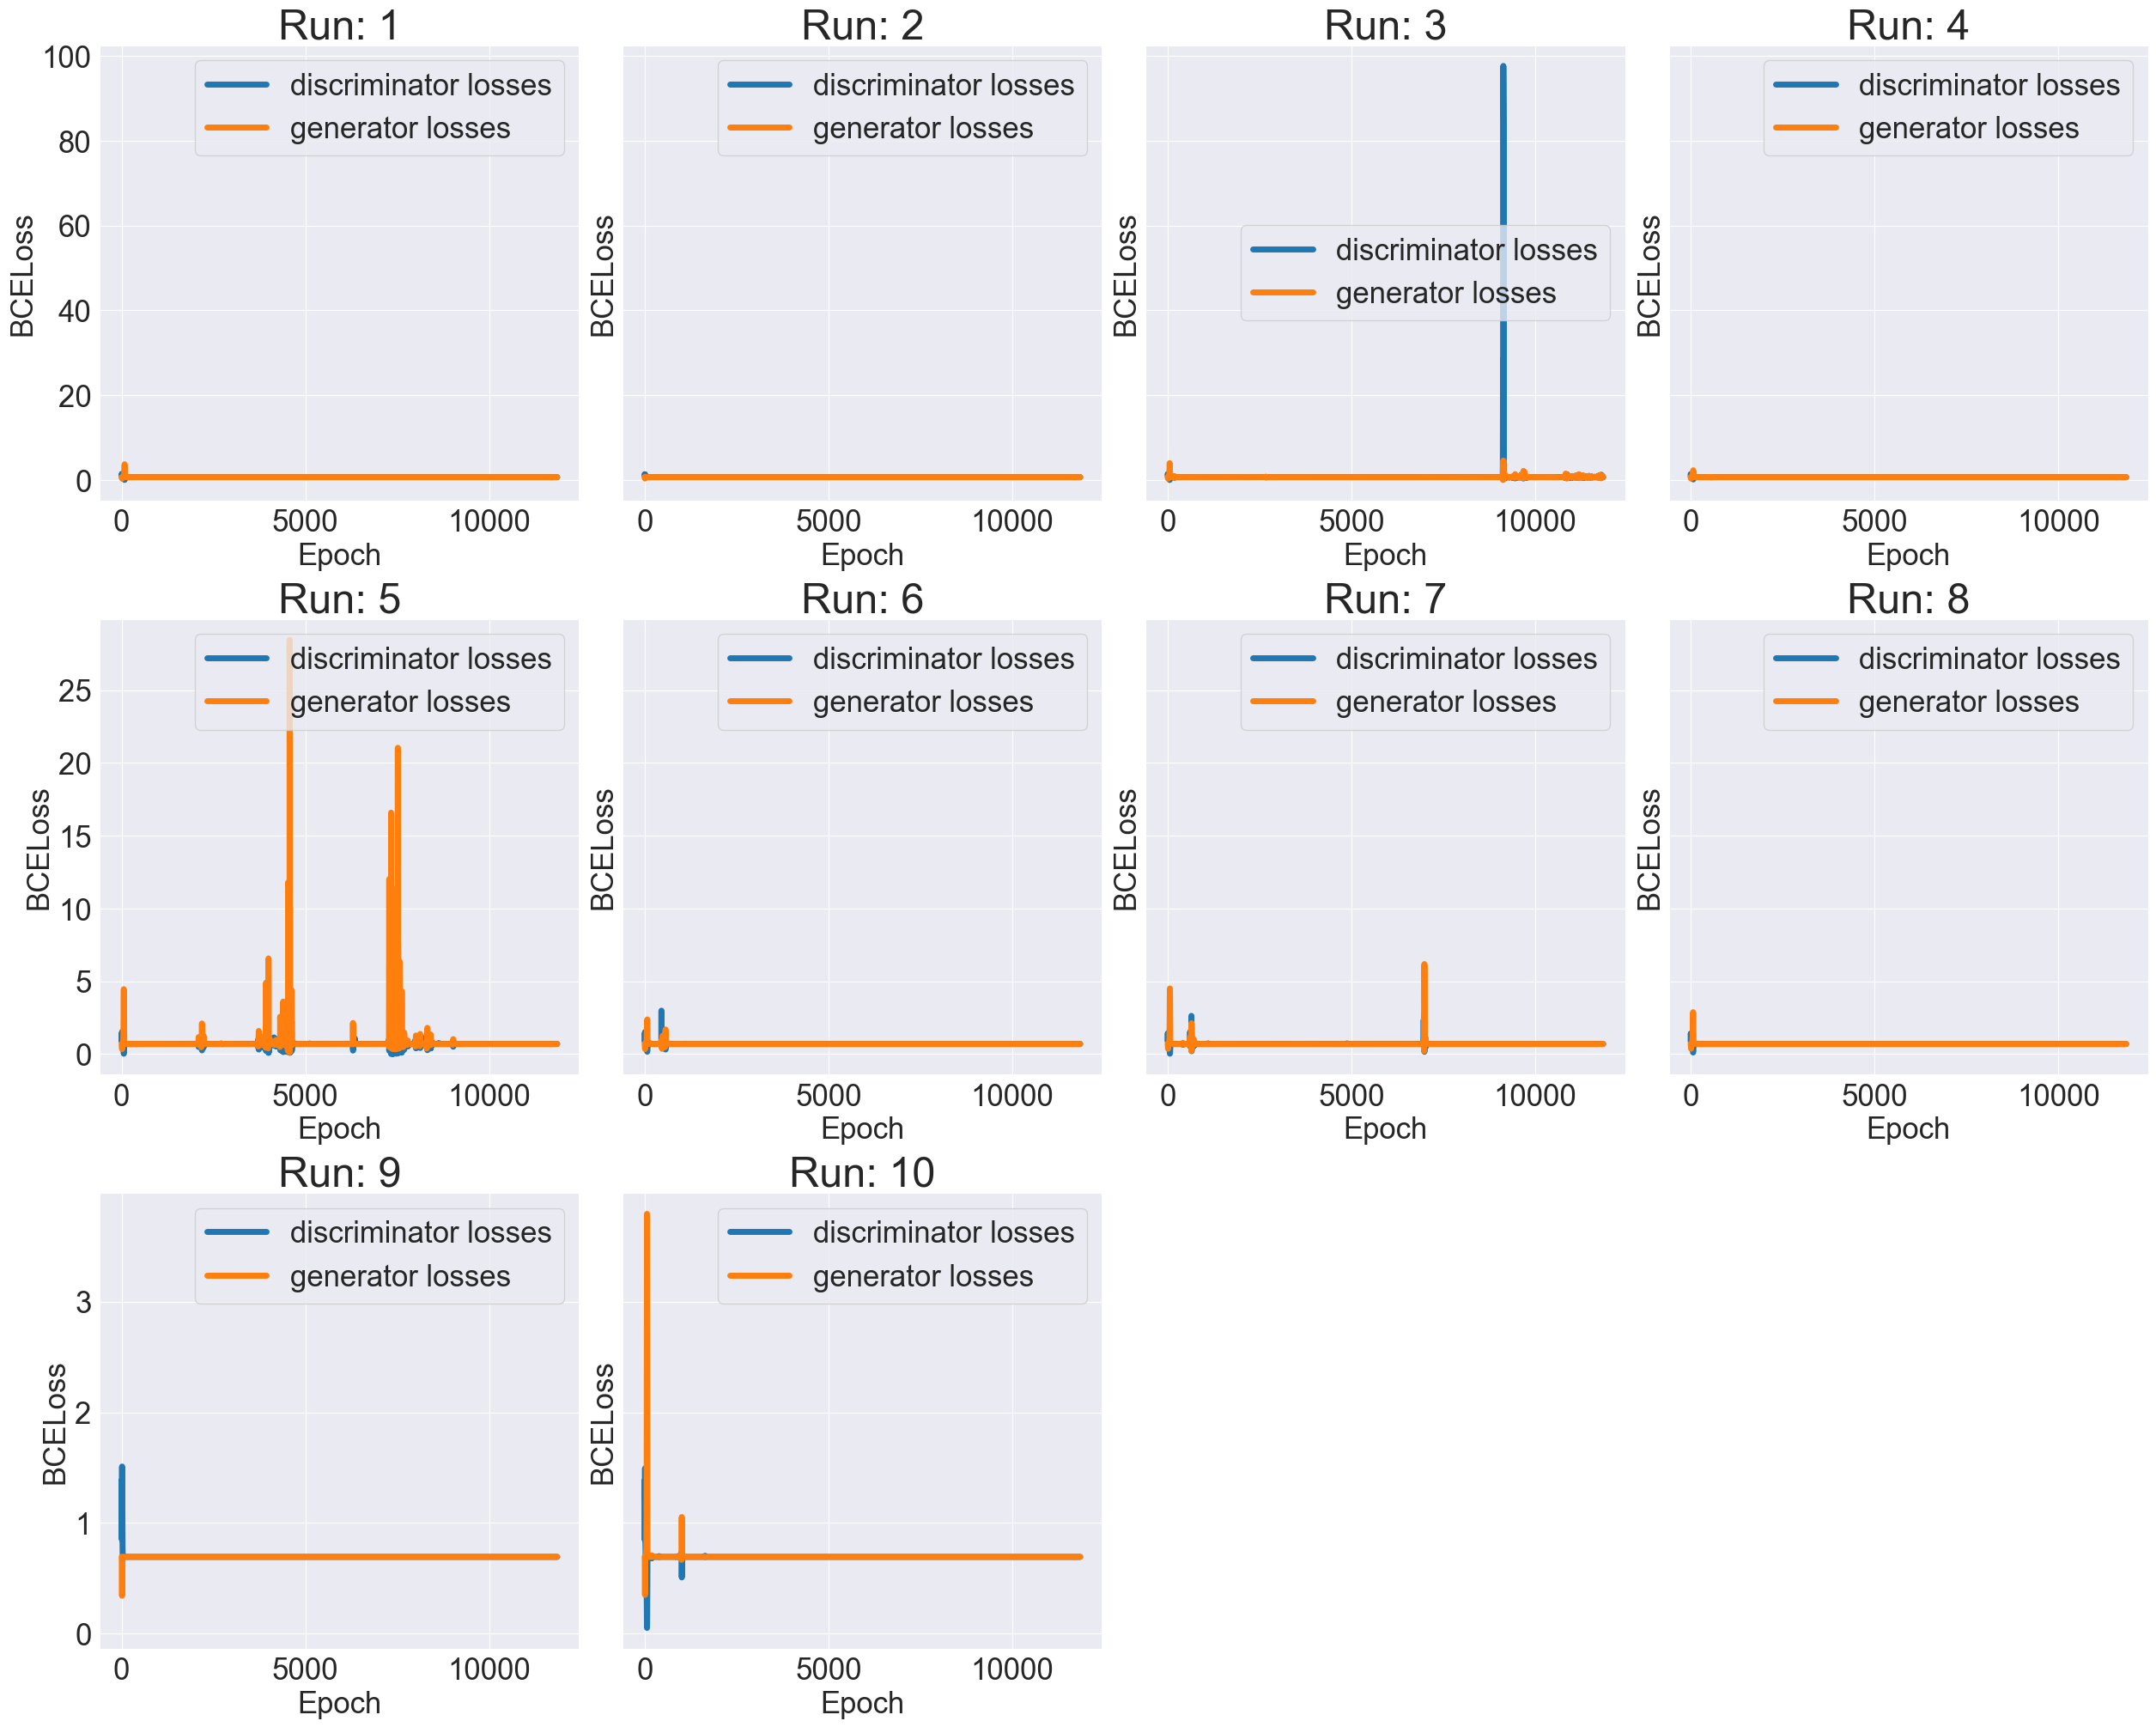

In [14]:
fig, ax = plt.subplots(3,4, figsize=(25,20), sharey='row', layout='constrained')
for i in range(len(res_df)):
    plot_run(res_df.iloc[i,2], f"Run: {res_df.iloc[i, 1]}", ax[i//4,i%4])
fig.delaxes(ax[2,2])
fig.delaxes(ax[2,3])
plt.show()

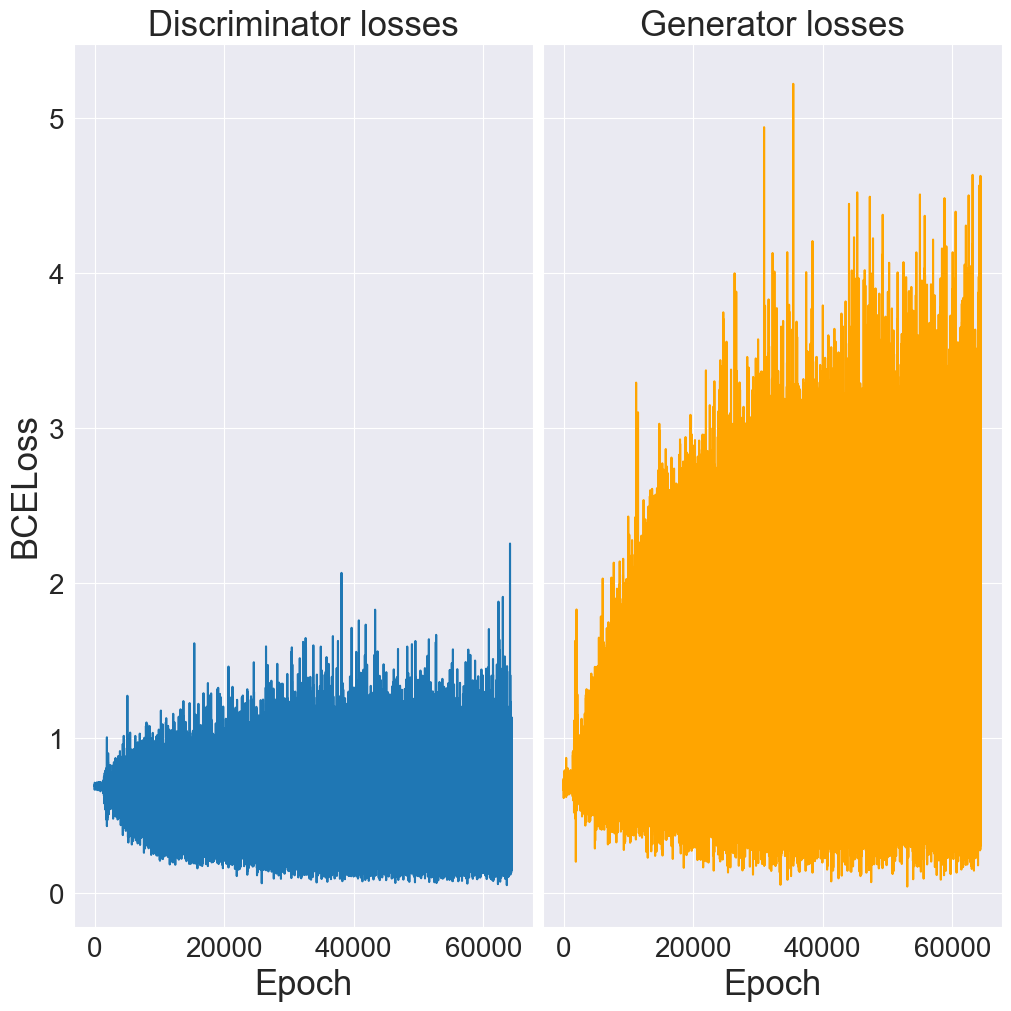

In [5]:
import ast
results = []
with open(path+"/"+'cdgan_trajectory.json') as f:
    for line in f.readlines():
        if line.startswith('['):
            results.append(ast.literal_eval(line[1:-2]))
        else:
            results.append(ast.literal_eval(line[:-2]))

df_cdgan = pd.DataFrame.from_records(results)
fig, ax = plt.subplots(1, 2, figsize=(10,10), layout='constrained', sharey='all')
ax[0].plot(df_cdgan['D loss'])
ax[0].set_title("Discriminator losses", fontsize=25)
ax[0].tick_params(axis='both', labelsize=20)
ax[0].set_ylabel("BCELoss", fontsize=25)
ax[0].set_xlabel("Epoch", fontsize=25)
ax[1].plot(df_cdgan['G loss'], c='orange')
ax[1].set_title("Generator losses", fontsize=25)
ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_xlabel("Epoch", fontsize=25)
plt.show()

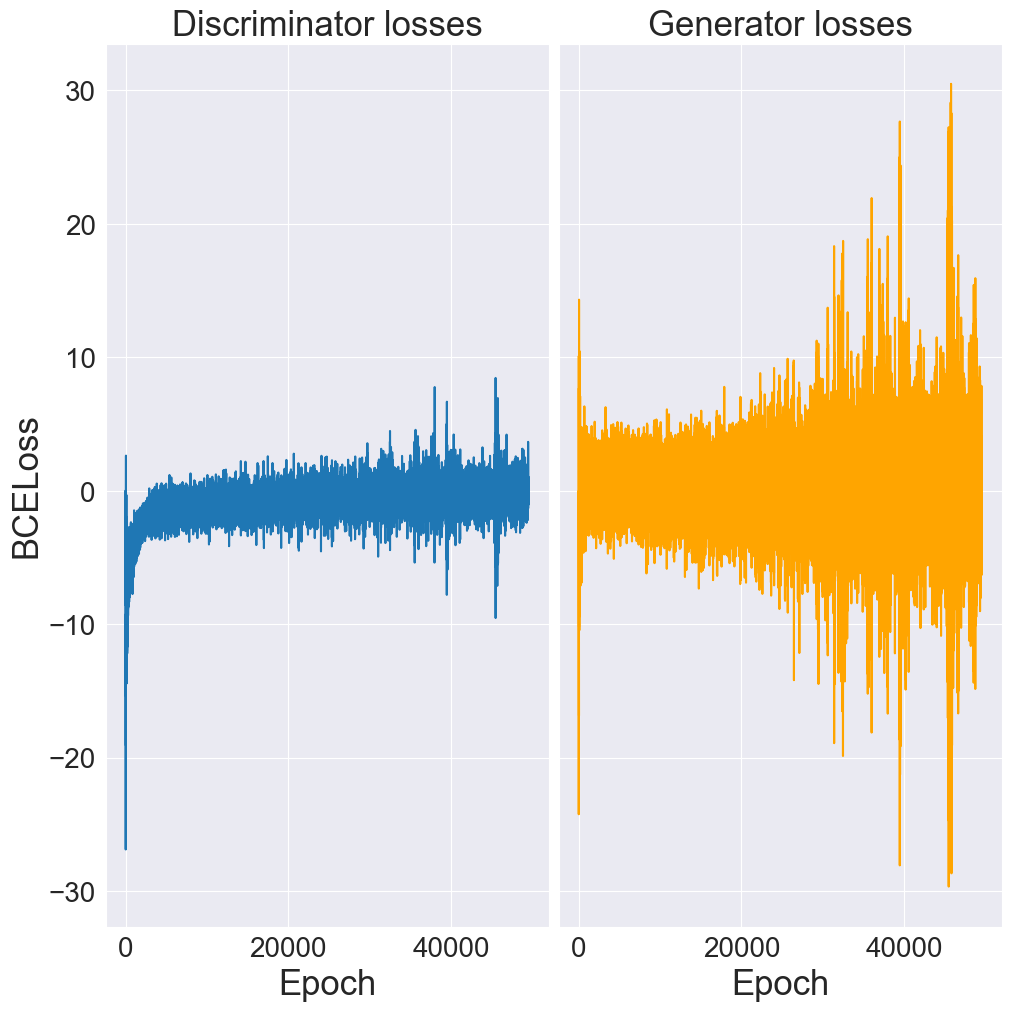

In [6]:
import ast
results = []
with open(path+"/"+'wgan_trajectory.json') as f:
    for line in f.readlines():
        if line.startswith('['):
            results.append(ast.literal_eval(line[1:-2]))
        else:
            results.append(ast.literal_eval(line[:-2]))

df_cdgan = pd.DataFrame.from_records(results)
fig, ax = plt.subplots(1, 2, figsize=(10,10), layout='constrained', sharey='all')
ax[0].plot(df_cdgan['D loss'])
ax[0].set_title("Discriminator losses", fontsize=25)
ax[0].tick_params(axis='both', labelsize=20)
ax[0].set_ylabel("BCELoss", fontsize=25)
ax[0].set_xlabel("Epoch", fontsize=25)
ax[1].plot(df_cdgan['G loss'], c='orange')
ax[1].set_title("Generator losses", fontsize=25)
ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_xlabel("Epoch", fontsize=25)
plt.show()


In [7]:
from torch import nn
import torch
from torch import Tensor
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image

In [8]:
class Options:
    def __init__(self):
        self.n_epochs = 200
        self.batch_size = 64
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 64
        self.channels = 3
        self.sample_interval = 400

opt = Options()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [9]:
generator = torch.load('experiments_gan/cdgan_generator_epoch_134.pt', map_location=torch.device('cpu'))

In [10]:
input1 = Tensor(np.random.normal(0,1,(1,100)))
input2 = Tensor(np.random.normal(0,1,(1,100)))

In [11]:
def interpolate(vec1, vec2, alpha):
    return (1 - alpha) * vec1 + alpha * vec2

In [12]:
alphas = np.linspace(0,1,10)

In [13]:
vectors = []
for alpha in alphas:
    vectors.append(interpolate(input1, input2, alpha))

vectors = torch.stack(vectors)
ims = generator(vectors)

from torchvision.utils import save_image
save_image(ims, "interpolate.png", nrow=2, normalize=True)